# Feature Engineering into LightGBM

Portions of code resued from:

https://www.kaggle.com/hhstrand/oof-stacking-regime/code
https://www.kaggle.com/jagangupta/stop-the-s-toxic-comments-eda

In [597]:
import os
import glob
import string

import pandas as pd
import numpy as np
import re
import lightgbm as lgb
import warnings

from sklearn.model_selection import cross_val_score, RandomizedSearchCV

import matplotlib.pyplot as plt;

%matplotlib inline

warnings.filterwarnings(action='ignore', category=DeprecationWarning, module='sklearn')

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score
from nltk.corpus import stopwords
from time import time

eng_stopwords = set(stopwords.words("english"))

text_file = open("compiled_bad_words.txt", "r");
bad_words = text_file.read().split('\n')
text_file.close()

# Define Features

In [783]:
#######################
# FEATURE ENGINEERING #
#######################
"""
Main function
Input: pandas Series and a feature engineering function
Output: pandas Series
"""
def engineer_feature(series, func, normalize=True):
    feature = series.apply(func)
       
    if normalize:
        feature = pd.Series(z_normalize(feature.values.reshape(-1,1)).reshape(-1,))
    feature.name = func.__name__ 
    return feature

"""
Engineer features
Input: pandas Series and a list of feature engineering functions
Output: pandas DataFrame
"""
def engineer_features(series, funclist, normalize=True):
    features = pd.DataFrame()
    for func in funclist:
        print(str(func))
        feature = engineer_feature(series, func, normalize)
        features[feature.name] = feature
    return features

##################
### Normalizer ###
##################

scaler = StandardScaler()
def z_normalize(data):
    scaler.fit(data)
    return scaler.transform(data)
    
################
### Features ###
################

def asterix_freq(x):
    return x.count('!')/len(x)

def uppercase_freq(x):
    return len(re.findall(r'[A-Z]', x))/len(x)

def sentence_count(x):
    return len(re.findall("\n", str(x)))+1

def word_count(x):
    return len(str(x).split())

def unique_word_count(x):
    return len(set(str(x).split()))

def count_letters(x):
    return len(str(x))

def count_punctuations(x):
    return len([c for c in str(x) if c in string.punctuation])

def count_words_title(x):
    return len([w for w in str(x).split() if w.istitle()])

def count_stopwords(x):
    return len([w for w in str(x).lower().split() if w in eng_stopwords])

def mean_word_len(x):
    words = [len(w) for w in str(x).split()]

    if len(words) == 0:
        return 0
    else:
        return np.mean(words)

########################
### Derived Features ###
########################

def unique_word_ratio(x):
    wc = word_count(x)
    
    if wc == 0:
        return 0
    else:
        return unique_word_count(x)/wc

def percent_ratio(x):
    wc = word_count(x)
    
    if wc == 0:
        return 0
    else:
        return count_punctuations(x)/wc

def words_per_sentence(x):
    sc = sentence_count(x)
    
    if sc == 0:
        return 0
    else:
        return word_count(x)/sc

####################
### New Features ###
####################

def count_bad_words(x):
    return len([w for w in str(x).lower().split() if w in bad_words])

def contains_ip(x):
    return len(re.findall(r'\d{1,3}\.\d{1,3}\.\d{1,3}\.\d{1,3}', x))

def contains_link(x):
    return len(re.findall('http://.*com', x))

def contains_utc(x):
    return len(re.findall('UTC', x))

def count_nonalphanum(x):
    return len(re.sub(r'[a-zA-Z0-9 ]*', '', x))

def contains_article_id(x):
    return len(re.findall("\d:\d\d\s{0,5}$", x))

def contains_user(x):
    return len(re.findall("\[\[User(.*)\|", x))

In [784]:
train = pd.read_csv('train_split.csv').fillna(' ')
valid = pd.read_csv('valid_split.csv').fillna(' ')
test  = pd.read_csv('test.csv').fillna(' ')
sub   = pd.read_csv('sample_submission.csv')

INPUT_COLUMN = "comment_text"
LABELS = train.columns[2:]

In [785]:
feature_functions = [asterix_freq, uppercase_freq, sentence_count, word_count, unique_word_count, count_letters,
                     count_punctuations, count_words_title, count_stopwords, mean_word_len, 
                     contains_ip, contains_link, contains_utc, count_nonalphanum, contains_article_id, contains_user,
                     unique_word_ratio, percent_ratio, words_per_sentence,
                     count_bad_words]

features = [f.__name__ for f in feature_functions]

F_train = engineer_features(train[INPUT_COLUMN], feature_functions)
F_valid = engineer_features(valid[INPUT_COLUMN], feature_functions)
F_test  = engineer_features(test[INPUT_COLUMN],  feature_functions)

X_train = F_train[features].as_matrix()
X_valid = F_valid[features].as_matrix()
X_test  = F_test[features].as_matrix()

<function asterix_freq at 0x0000028EB686F620>
<function uppercase_freq at 0x0000028ECDA9E400>
<function sentence_count at 0x0000028ECDA9EAE8>


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


<function word_count at 0x0000028ECDA9EBF8>
<function unique_word_count at 0x0000028ECDA9EB70>
<function count_letters at 0x0000028ECDA9EA60>
<function count_punctuations at 0x0000028ECDA9E488>
<function count_words_title at 0x0000028ECDA9EC80>
<function count_stopwords at 0x0000028ECDA9ED08>
<function mean_word_len at 0x0000028ECDA9E950>
<function contains_ip at 0x0000028ECDA9E620>
<function contains_link at 0x0000028ECDA9E598>
<function contains_utc at 0x0000028ECDA9E510>
<function count_nonalphanum at 0x0000028ECDA9E0D0>
<function contains_article_id at 0x0000028ECDA9E158>
<function contains_user at 0x0000028ECDA9E048>
<function unique_word_ratio at 0x0000028ECDA9E9D8>
<function percent_ratio at 0x0000028ECDA9E6A8>
<function words_per_sentence at 0x0000028ECDA9E7B8>
<function count_bad_words at 0x0000028ECDA9E730>
<function asterix_freq at 0x0000028EB686F620>
<function uppercase_freq at 0x0000028ECDA9E400>
<function sentence_count at 0x0000028ECDA9EAE8>
<function word_count at 0x000

In [786]:
model = lgb.LGBMClassifier(max_depth=3, metric="auc", n_estimators=125, num_leaves=10, boosting_type="gbdt", 
                             learning_rate=0.1, feature_fraction=0.45, colsample_bytree=0.45, bagging_fraction=0.8, 
                             bagging_freq=5, reg_lambda=0.2, is_unbalance=True)

In [792]:
scores = []

for label in LABELS:
    score = cross_val_score(model, X_train, train[label], cv=5, scoring='roc_auc')
    print(str(label) + '\nAverage Score = {}\nStandard Deviation = {}'.format(np.mean(score), np.std(score)))
    print("\n")
    scores.append(np.mean(score))
    model.fit(X_train, train[label], feature_name=[feature.__name__ for feature in feature_functions])
    sub[label] = model.predict_proba(X_test)[:, 1]
    
print('\nOverall\nAverage Score = {}\nOverall Standard Deviation = {}'.format(np.mean(scores), np.std(scores)))

toxic
Average Score = 0.8838742771247274
Standard Deviation = 0.0016827884401708442


severe_toxic
Average Score = 0.9737784890368708
Standard Deviation = 0.002462793766906375


obscene
Average Score = 0.9368899796194186
Standard Deviation = 0.0039287217173607294


threat
Average Score = 0.9032831745441344
Standard Deviation = 0.019345950859598747


insult
Average Score = 0.909277323426821
Standard Deviation = 0.0043587657172559965


identity_hate
Average Score = 0.8994026530596709
Standard Deviation = 0.012580574097553079



Overall
Average Score = 0.9177509828019405
Overall Standard Deviation = 0.02963892548925696


# Examine Feature Importances

Note that for "count_bad_words" in particular there is a huge difference in importantace as determined by splitting versus gain. The CV score increased a ton by including this feature.

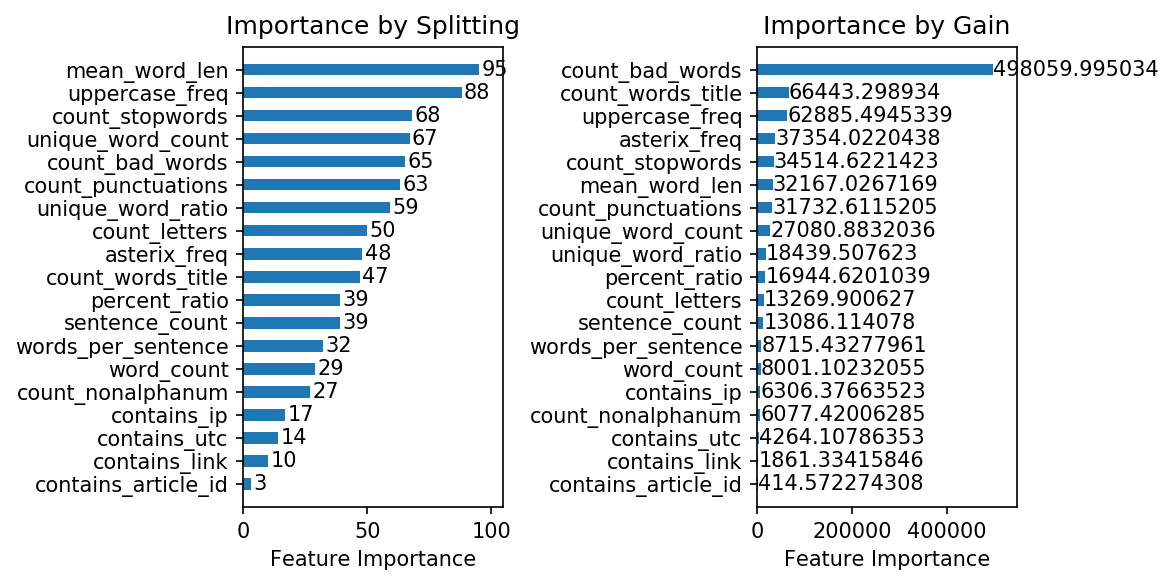

In [790]:
fig = plt.figure(figsize=(7, 4), dpi=150)

ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)

lgb.plot_importance(model, height=0.5, ax=ax1, importance_type='split', xlabel='Feature Importance', ylabel=None)
lgb.plot_importance(model, height=0.5, ax=ax2, importance_type='gain',  xlabel='Feature Importance', ylabel=None)

ax1.grid(False);ax2.grid(False);
ax1.set_title('Importance by Splitting');ax2.set_title('Importance by Gain');

fig.tight_layout()

# Export Predictions

In [794]:
sub.to_csv("18_03_16_BaseLine_FeatureEngineering_localAUC9177.csv", index=False)